# Import all necessary dependecies and scraped data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
f1_events_info = pd.read_csv("/content/drive/MyDrive/formula_one/f1_events_info_2025.csv")
f1_driver_telemetry = pd.read_csv("/content/drive/MyDrive/formula_one/f1_driver_telemetry_info_2025.csv")
f1_driver_laps_info = pd.read_csv("/content/drive/MyDrive/formula_one/f1_driver_laps_info_2025.csv")
f1_fia_control_info = pd.read_csv("/content/drive/MyDrive/formula_one/f1_fia_control_info_2025.csv")
f1_results_info = pd.read_csv("/content/drive/MyDrive/formula_one/f1_results_info_2025.csv")
f1_weather_info = pd.read_csv("/content/drive/MyDrive/formula_one/f1_weather_info_2025.csv")

Just for testing example i will deal only with first race weekend of 2025 season.

In [ ]:
f1_events_info.head(5)

,MeetingKey,SessionKey,WeekendNumber,ShortName,FullName,CountryName,LocationType,CircuitName,SessionType,SessionName,StartDate,EndDate,GmtOffset
0,1254,9686,1,Australian Grand Prix,FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX ...,Australia,Melbourne,Melbourne,Practice,Practice 1,2025-03-14 12:30:00,2025-03-14 13:30:00,0 days 11:00:00
1,1254,9687,1,Australian Grand Prix,FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX ...,Australia,Melbourne,Melbourne,Practice,Practice 2,2025-03-14 16:00:00,2025-03-14 17:00:00,0 days 11:00:00
2,1254,9688,1,Australian Grand Prix,FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX ...,Australia,Melbourne,Melbourne,Practice,Practice 3,2025-03-15 12:30:00,2025-03-15 13:30:00,0 days 11:00:00
3,1254,9689,1,Australian Grand Prix,FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX ...,Australia,Melbourne,Melbourne,Qualifying,Qualifying,2025-03-15 16:00:00,2025-03-15 17:00:00,0 days 11:00:00
4,1254,9693,1,Australian Grand Prix,FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX ...,Australia,Melbourne,Melbourne,Race,Race,2025-03-16 15:00:00,2025-03-16 17:00:00,0 days 11:00:00


In [ ]:
# make Australia's weekend dataframes like w1
w1_events = f1_events_info[f1_events_info["MeetingKey"] == 1254]
w1_laps = f1_driver_laps_info[f1_driver_laps_info["MeetingKey"] == 1254]
w1_fia_control = f1_fia_control_info[f1_fia_control_info["MeetingKey"] == 1254]
w1_results = f1_results_info[f1_results_info["MeetingKey"] == 1254]
w1_weather = f1_weather_info[f1_weather_info["MeetingKey"] == 1254]
w1_driver_telemetry = f1_driver_telemetry[f1_driver_telemetry["MeetingKey"] == 1254]

# EDA of each specific session

The main purpose of this dataset is to find out what weekend statistic i can grab from f1 weekend events and how i can visualize it to use it in my final tg bot.

## Practice sessions

By each weekend we have 3 practice sessions, qualification session and final race session or we can have practice session, sprint qualification session, sprint race, race qualification and final race qualification. Sprint quite similar to common race but supposed to be without pit stops (not always), what means that we can use similar analysis techniques like for race session. Same for qualification session.

In [ ]:
practice_sessions = w1_events[w1_events['SessionType']=='Practice']['SessionKey'].tolist()
w1_results[w1_results["SessionKey"].isin(practice_sessions)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 59
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MeetingKey          60 non-null     int64  
 1   SessionKey          60 non-null     int64  
 2   Abbreviation        60 non-null     object 
 3   FullName            60 non-null     object 
 4   DriverNumber        60 non-null     int64  
 5   TeamName            60 non-null     object 
 6   TeamColor           60 non-null     object 
 7   HeadshotUrl         60 non-null     object 
 8   Position            0 non-null      float64
 9   ClassifiedPosition  0 non-null      object 
 10  GridPosition        0 non-null      float64
 11  Q1                  0 non-null      object 
 12  Q2                  0 non-null      object 
 13  Q3                  0 non-null      object 
 14  Time                0 non-null      object 
 15  Status              0 non-null      object 
 16  Points         

as see we have no classified position, time or whatever interesting besides drivers information in free practice session, so all possible interesting information during fp1, fp2 or fp3 are in driver laps dataframe, weather dataframe or fia control dataset. Also for practicies i didn't scrape information about driver telemetry, because in general we have a lot of unnecessary data which not really interesting analyse during a simple practicies. That also relate to some boring mood about practicies.

In [ ]:
# convert string time data into datetime type
def convert_to_datetime(value):
    try:
        if pd.isna(value) or value == "NaN":
            return None
        timedelta_value = pd.to_timedelta(value)
        return timedelta_value
    except Exception as e:
        return None

In [ ]:
w1_laps["LapTime"] = w1_laps["LapTime"].apply(convert_to_datetime)
w1_fp1_laps = w1_laps[w1_laps["SessionKey"] == practice_sessions[0]]
w1_fp1_laps.head()

,MeetingKey,SessionKey,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,1254,9686,0 days 00:17:15.002000,VER,1,0 days 00:01:58.029000,1.0,1.0,0 days 00:15:28.184000,NaN,...,True,Red Bull Racing,0 days 00:15:28.184000,2025-03-14 01:30:56.193,1,NaN,False,NaN,False,False
1,1254,9686,0 days 00:18:34.773000,VER,1,0 days 00:01:19.771000,2.0,1.0,NaN,NaN,...,True,Red Bull Racing,0 days 00:17:15.002000,2025-03-14 01:32:43.011,1,NaN,False,NaN,False,True
2,1254,9686,0 days 00:20:58.688000,VER,1,0 days 00:02:23.915000,3.0,1.0,NaN,NaN,...,True,Red Bull Racing,0 days 00:18:34.773000,2025-03-14 01:34:02.782,1,NaN,False,NaN,False,True
3,1254,9686,0 days 00:22:17.837000,VER,1,0 days 00:01:19.149000,4.0,1.0,NaN,NaN,...,True,Red Bull Racing,0 days 00:20:58.688000,2025-03-14 01:36:26.697,1,NaN,False,NaN,False,True
4,1254,9686,0 days 00:24:46.613000,VER,1,0 days 00:02:28.776000,5.0,1.0,NaN,NaN,...,True,Red Bull Racing,0 days 00:22:17.837000,2025-03-14 01:37:45.846,1,NaN,False,NaN,False,True


In [ ]:
def get_session_df(df, session_key):
  return df[df["SessionKey"] == session_key]


def convert_time_into_string(value):
    try:
      minutes = int(value.total_seconds() // 60)
      seconds = int(value.total_seconds() % 60)
      milliseconds = int(value.microseconds // 1000)

      return f"{minutes}:{seconds:02}.{milliseconds:03}"
    except:
      return np.nan

### Practice session statistic and results

In [ ]:
# create practice session statistic table

w1_fp1_laps = w1_laps[w1_laps["SessionKey"] == practice_sessions[2]]

temp_1_df = (
    w1_fp1_laps[w1_fp1_laps["Deleted"] == False].groupby(["Driver", "Team"]).agg(
        FastetLapTime=("LapTime", "min"),
        UsedTypeTyres=("Compound", "unique"),
        Laps=('LapNumber', lambda x: int(x.max()))).reset_index()
)

fastest_lap = temp_1_df['FastetLapTime'].min()
temp_1_df['TimeGapTime'] = temp_1_df['FastetLapTime'] - fastest_lap
temp_1_df['TimeGap'] = temp_1_df['FastetLapTime'].apply(convert_time_into_string)  # (temp_1_df['FastetLapTime'])
temp_1_df['TimeGap'] = temp_1_df['TimeGapTime'].apply(
    lambda x: (
        f"+{x.total_seconds():.3f}" if (0 < x.total_seconds() <= 10)
        else '—'
        if (pd.isnull(x) or x.total_seconds() > 10)
        else temp_1_df.loc[temp_1_df['FastetLapTime'].idxmin(), 'TimeGap']
    )
)

temp_2_df = (
    temp_1_df.merge(
        w1_fp1_laps[w1_fp1_laps["Deleted"] == False],
        left_on=["Driver", "Team", "FastetLapTime"],
        right_on=["Driver", "Team", "LapTime"],
        how="left"
    )
    .rename(columns={"Compound": "FastestLapTyre"})
    .sort_values(by="FastetLapTime", ascending=True)
)

temp_2_df["UsedTypeTyres"] = [', '.join(map(str, l)) for l in temp_2_df["UsedTypeTyres"]]
temp_2_df = temp_2_df.reset_index(drop=True)
temp_2_df["Position"] = temp_2_df.index + 1
temp_2_df = temp_2_df[["Position", "Driver", "Team", "TimeGap", "Laps", "FastestLapTyre", "UsedTypeTyres"]]
temp_2_df.drop_duplicates(subset=['Driver', 'Team'], inplace=True)
temp_2_df

# can add in UsedTypeTyres info like MEDIUM(13), SOFT(8)

,Position,Driver,Team,TimeGap,Laps,FastestLapTyre,UsedTypeTyres
0,1,PIA,McLaren,1:15.921,16,SOFT,"HARD, SOFT"
1,2,RUS,Mercedes,+0.039,17,SOFT,SOFT
2,3,VER,Red Bull Racing,+0.081,18,SOFT,SOFT
3,4,LEC,Ferrari,+0.267,22,SOFT,"HARD, MEDIUM, SOFT"
4,5,ANT,Mercedes,+0.285,20,SOFT,SOFT
5,6,SAI,Williams,+0.331,23,SOFT,"HARD, SOFT"
6,7,ALB,Williams,+0.337,21,SOFT,"HARD, SOFT"
7,8,HAM,Ferrari,+0.457,21,SOFT,"HARD, MEDIUM, SOFT"
8,9,TSU,Racing Bulls,+0.534,17,SOFT,"HARD, SOFT"
9,10,NOR,McLaren,+0.676,20,SOFT,"HARD, SOFT"


so for driver statistic that is all to be honest. From that we see the fastest lap of each specific driver and what tyre they use for that, also we see what tyre they use in overall during sessions. From this table we see that Lawson (LAW) and Bearman (BEA) don't put their fastest lap, means that crash may exist. See also that second Haas driver Ocon can't put decent fastest lap to competitive with other drivers. And finally pretty impressive that both Williams into top10.

### Weather report during session

In [ ]:
# let's see when was first and last lap time
w1_laps["Time"] = w1_laps["Time"].apply(convert_to_datetime)
session_key_fp = practice_sessions[0]
session_start = w1_laps[w1_laps["SessionKey"] == session_key_fp]["Time"].min()
session_end = w1_laps[w1_laps["SessionKey"] == session_key_fp]["Time"].max()
print(session_start)
print(session_end)

0 days 00:16:32.768000
0 days 01:20:27.230000


In [ ]:
w1_weather["Time"] = w1_weather["Time"].apply(convert_to_datetime)

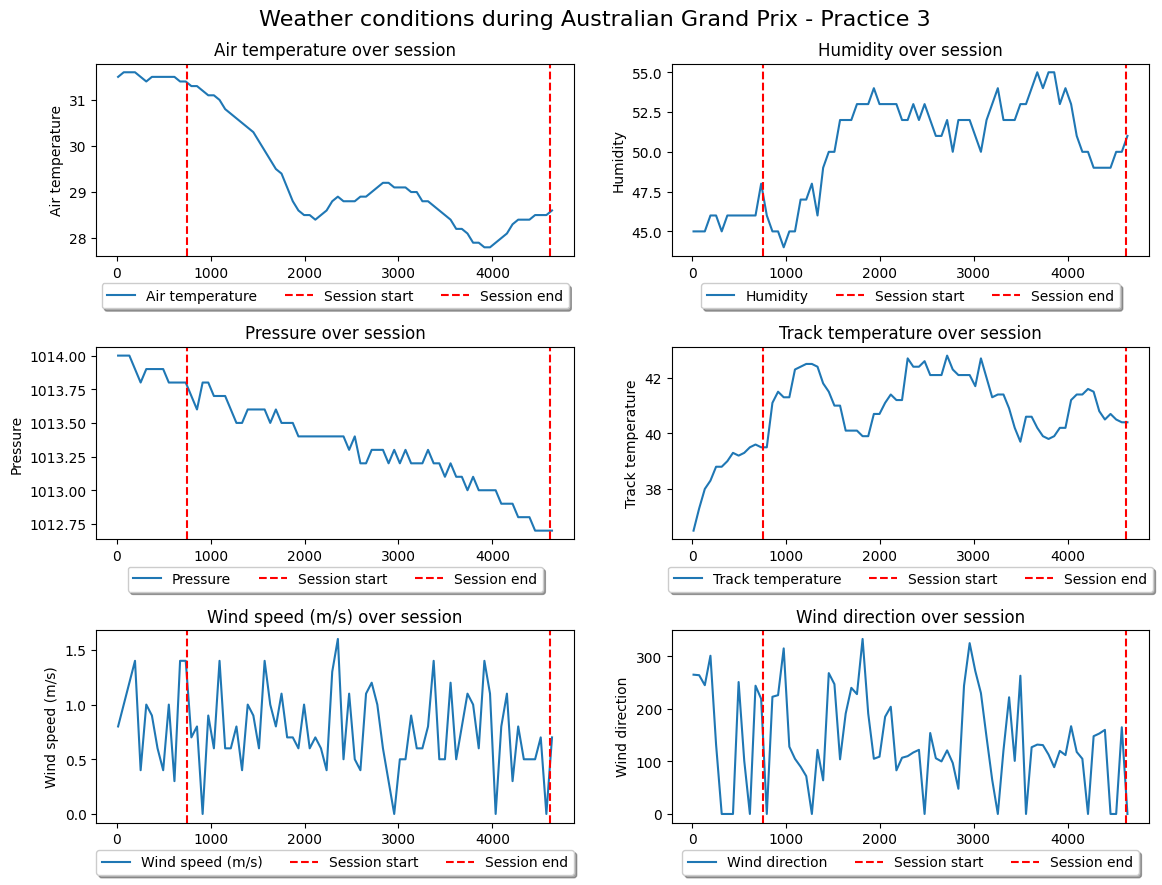

In [ ]:
def session_weather_plotting(ax, session_weather_df, weather_value, weather_type, session_start_seconds, session_end_seconds):
  ax.plot(session_weather_df["TimeSeconds"], session_weather_df[weather_value], label=weather_type)
  ax.axvline(x=session_start_seconds, color="red", linestyle="--", label="Session start")
  ax.axvline(x=session_end_seconds, color="red", linestyle="--", label="Session end")

  ax.set_xlabel("Time (seconds)")
  ax.set_ylabel(weather_type)
  ax.legend(loc='upper center',
            bbox_to_anchor=(0.5, -0.105),
            fancybox=True,
            shadow=True,
            ncol=5
            )
  ax.set_title(f"{weather_type} over session")


weather_dict = {
    "Air temperature": "AirTemp",
    "Humidity": "Humidity",
    "Pressure": "Pressure",
    "Track temperature": "TrackTemp",
    "Wind speed (m/s)": "WindSpeed",
    "Wind direction": "WindDirection"
}

pick_session_key = practice_sessions[2]
# pick_session_key = 9693
w1_event_weather = get_session_df(w1_weather, pick_session_key)
temp_small_event_df = w1_events[w1_events['SessionKey'] == pick_session_key]
w1_event_weather["TimeSeconds"] = w1_event_weather["Time"].dt.total_seconds()

session_laps_df = get_session_df(w1_laps, pick_session_key)
session_start = session_laps_df["Time"].min()
session_start_seconds = session_start.total_seconds()

session_end = session_laps_df["Time"].max()
session_end_seconds = session_end.total_seconds()

fig, axes = plt.subplots(3, 2, figsize=(12, 9))
axes = axes.flatten()

for ax, (weather_type, weather_value) in zip(axes, weather_dict.items()):
    session_weather_plotting(ax, w1_event_weather, weather_value, weather_type, session_start_seconds, session_end_seconds)

fig.suptitle(f"Weather conditions during {temp_small_event_df.iloc[:, 3].values[0]} - {temp_small_event_df.iloc[:, 9].values[0]}", fontsize=16)
plt.tight_layout()
plt.show()

This weather report can be applied to all F1 session types (free practice, both qualifications, sprint race, and race) to provide valuable insights into the weather's impact on each session. It also reveals pre-session conditions, which are critical, as heavy rain before a session can significantly affect tire strategy and overall session behavior. But let's also see on rainfall data.

In [ ]:
def visualize_rainfall_data_through_session(weather_data, laps_data, event_data, session_key, rains_data={True: '#00FFFF', False: '#ADD8E6'}):
  # rains_data = {True: '#00FFFF', False: '#ADD8E6'}
  event_short_data = get_session_df(event_data, session_key)
  session_weather_data = get_session_df(w1_weather, session_key)
  session_weather_data["TimeSeconds"] = session_weather_data["Time"].dt.total_seconds()
  plt.figure(figsize=(10, 1))

  previous_rain_info = 0
  legend_labels = {}

  session_laps_data = get_session_df(laps_data, session_key)
  session_start = session_laps_data["Time"].min()
  session_end = session_laps_data["Time"].max()

  session_start_seconds = session_start.total_seconds()
  session_end_seconds = session_end.total_seconds()

  for _, rain_info in session_weather_data.iterrows():
      color = rains_data.get(rain_info['Rainfall'])

      if rain_info['Rainfall'] not in legend_labels:
          legend_labels[rain_info['Rainfall']] = plt.barh(
              'Rainfall data', rain_info['TimeSeconds'] - previous_rain_info,
              left=previous_rain_info, color=color, label=rain_info['Rainfall']
          )
      else:
          plt.barh('Rainfall data', rain_info['TimeSeconds'] - previous_rain_info,
                  left=previous_rain_info, color=color)

      previous_rain_info = rain_info['TimeSeconds']

  plt.legend(handles=legend_labels.values(),
            labels=legend_labels.keys(),
            loc='upper center',
            bbox_to_anchor=(0.5, -0.24),
            fancybox=True,
            shadow=True,
            ncol=5
            )

  plt.axvline(x=session_start_seconds, color="red", linestyle="--")
  plt.axvline(x=session_end_seconds, color="red", linestyle="--")
  plt.title(f"Rainfall condition during {event_short_data.iloc[:, 3].values[0]} - {event_short_data.iloc[:, 9].values[0]}")

  plt.show()

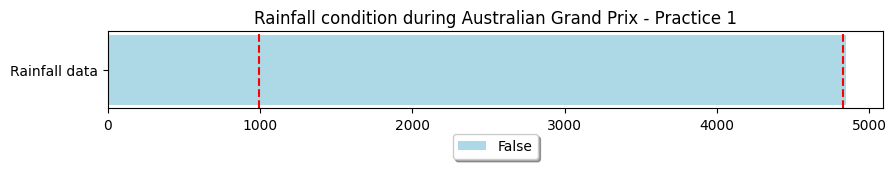

In [ ]:
visualize_rainfall_data_through_session(w1_weather, w1_laps, w1_events, 9686)

This section displays rainfall occurrence during the session. Regrettably, detailed rainfall data, such as intensity, is unavailable. We are limited to binary information: the presence or absence of rain.

### FIA control data

Also we can find any information in FIA control messages like flags (especially red, which restart session after some time (it is more significant in the race)), safety cars and really important things like penalties during race session. But it's not often in free practice.

In [ ]:
w1_f1_fia_control = w1_fia_control[w1_fia_control["SessionKey"] == practice_sessions[0]]
w1_f1_fia_control.head()

,MeetingKey,SessionKey,Time,Lap,Category,Message,Status,Flag,Scope,Sector,RacingNumber
0,1254,9686,2025-03-14 01:30:00,NaN,Flag,GREEN LIGHT - PIT EXIT OPEN,NaN,GREEN,Track,NaN,NaN
1,1254,9686,2025-03-14 01:48:31,NaN,Flag,RED FLAG,NaN,RED,Track,NaN,NaN
2,1254,9686,2025-03-14 01:53:58,NaN,Other,SESSION WILL RESUME AT 12:55,NaN,NaN,NaN,NaN,NaN
3,1254,9686,2025-03-14 01:54:03,NaN,Flag,TRACK CLEAR,NaN,CLEAR,Track,NaN,NaN
4,1254,9686,2025-03-14 01:54:05,NaN,Drs,DRS ENABLED,ENABLED,NaN,NaN,NaN,NaN


In [ ]:
red_flags = w1_f1_fia_control[w1_f1_fia_control['Flag'] == 'RED'].shape[0]
print(f"Number of red flags during session: {red_flags}")

Number of red flags during session: 2


Wow, pretty insane get 2 red flags during first free practice session of the season!

In [ ]:
# also check race fia control data
w1_r_fia_control = w1_fia_control[w1_fia_control["SessionKey"] == 9693]

In [ ]:
red_flags = w1_r_fia_control[w1_r_fia_control['Flag'] == 'RED'].shape[0]
print(f"Number of red flags during session: {red_flags}")

safety_car_deployed = w1_r_fia_control[(w1_r_fia_control['Category']=='SafetyCar') & (w1_r_fia_control['Status']=='DEPLOYED')]['Lap'].tolist()
safety_car_undeployed = w1_r_fia_control[(w1_r_fia_control['Category']=='SafetyCar') & (w1_r_fia_control['Status']=='IN THIS LAP')]['Lap'].tolist()

print('Safety car: ' + ', '.join(f'{int(sc_d)}-{int(sc_und)}' for sc_d, sc_und in zip(safety_car_deployed, safety_car_undeployed)))

penalty_list = w1_r_fia_control[w1_r_fia_control['Message'].str.contains('PENALTY', case=False, na=False)]['Message'].tolist()

driver_and_number = {}
session_results = w1_results[w1_results['SessionKey']==9693]

for row in session_results.itertuples():
  driver_and_number.update({row.DriverNumber: row.Abbreviation})

penalties_for_driver = {}

pattern = r"(\d+)\s+SECOND TIME PENALTY FOR CAR\s+(\d+)"
for fia_message in penalty_list:
  match_text = re.search(pattern, fia_message)
  if match_text:
    penalty_seconds = int(match_text.group(1))
    car_number = int(match_text.group(2))

    if 'PENALTY SERVED' in fia_message:
      if penalties_for_driver.get(driver_and_number.get(car_number), None) is not None:
        penalties_for_driver[driver_and_number.get(car_number)] -= penalty_seconds
      else:
        continue
    else:
      if penalties_for_driver.get(driver_and_number.get(car_number), None) is not None:
        penalties_for_driver[driver_and_number.get(car_number)] += penalty_seconds
      else:
        penalties_for_driver[driver_and_number.get(car_number)] = penalty_seconds

print('Penalty for drivers - ' + (', ').join(f'{driver_abr}: {penalty_sec} seconds' for driver_abr, penalty_sec in penalties_for_driver.items() if penalty_sec !=0))

Number of red flags during session: 0
Safety car: 1-7, 34-41, 47-51
Penalty for drivers - ANT: 5 seconds


The data indicates that rookie Kimi Antonelli received a 5-second penalty. However, Mercedes subsequently filed an appeal, which was successful in overturning the penalty. This appeal outcome is not reflected in the data and we can see that. But don't worry the driver points and constructor points are correct.

## Qualifying

Qualifying is much interesting then free practice and doesn't matter sprint or race qualification. We can observe Q1, Q2 and Q3 results and we can compare best drivers lap telemetry to see significat differences between drivers and cars capabilities.

In [ ]:
qual_australian_gp = w1_results[w1_results["SessionKey"] == 9689]
qual_australian_gp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 60 to 79
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MeetingKey          20 non-null     int64  
 1   SessionKey          20 non-null     int64  
 2   Abbreviation        20 non-null     object 
 3   FullName            20 non-null     object 
 4   DriverNumber        20 non-null     int64  
 5   TeamName            20 non-null     object 
 6   TeamColor           20 non-null     object 
 7   HeadshotUrl         20 non-null     object 
 8   Position            20 non-null     float64
 9   ClassifiedPosition  0 non-null      object 
 10  GridPosition        0 non-null      float64
 11  Q1                  19 non-null     object 
 12  Q2                  15 non-null     object 
 13  Q3                  10 non-null     object 
 14  Time                0 non-null      object 
 15  Status              0 non-null      object 
 16  Points        

### Qualification results

In [ ]:
qual_australian_gp["Q1_time"] = qual_australian_gp["Q1"].apply(convert_to_datetime).apply(convert_time_into_string)
qual_australian_gp["Q2_time"] = qual_australian_gp["Q2"].apply(convert_to_datetime).apply(convert_time_into_string)
qual_australian_gp["Q3_time"] = qual_australian_gp["Q3"].apply(convert_to_datetime).apply(convert_time_into_string)
qual_australian_gp[["DriverNumber", "Abbreviation", "TeamName", "Q1_time", "Q2_time", "Q3_time"]]

,DriverNumber,Abbreviation,TeamName,Q1_time,Q2_time,Q3_time
60,4,NOR,McLaren,1:15.912,1:15.415,1:15.096
61,81,PIA,McLaren,1:16.062,1:15.468,1:15.180
62,1,VER,Red Bull Racing,1:16.018,1:15.565,1:15.481
63,63,RUS,Mercedes,1:15.971,1:15.798,1:15.546
64,22,TSU,Racing Bulls,1:16.225,1:16.009,1:15.670
65,23,ALB,Williams,1:16.245,1:16.017,1:15.737
66,16,LEC,Ferrari,1:16.029,1:15.827,1:15.755
67,44,HAM,Ferrari,1:16.213,1:15.919,1:15.973
68,10,GAS,Alpine,1:16.328,1:16.112,1:15.980
69,55,SAI,Williams,1:16.360,1:15.931,1:16.062


The table above indicates that Albon and Tsunoda outperformed both Ferrari drivers in qualifying, which is a notable achievement. Also, Liam Lawson struggled significantly. Telemetry data would be particularly insightful in understanding his performance.

### Compare driver telemetry during one qualification session

In [ ]:
f1_driver_laps_info["LapStartTime"] = f1_driver_laps_info["LapStartTime"].apply(convert_to_datetime)

In [ ]:
qual_dict = {
    "Q1": 1,
    "Q2": 2,
    "Q3": 3,
}


def get_qualification_telemetry_df(laps_data, results_data, telemetry_data, fia_message_data, event_data, session_key, qual_dict, qual_session):
  event_name = get_session_df(event_data, session_key)['ShortName'].values[0]

  temp_qual_laps = get_session_df(laps_data, session_key)
  temp_qual_laps = temp_qual_laps[temp_qual_laps["Deleted"] == False]

  qual_green_time = fia_message_data[(fia_message_data["SessionKey"] == session_key) & (fia_message_data["Flag"] == 'GREEN')]['Time'].tolist()
  # qual_chequered_time = fia_message_data[(fia_message_data["SessionKey"] == session_key) & (fia_message_data["Flag"] == 'CHEQUERED')]['Time'].tolist()
  temp_qual_laps["SessionNumber"] = temp_qual_laps['LapStartDate'].apply(lambda x: 1 if x < qual_green_time[1] else 2 if qual_green_time[1] < x < qual_green_time[2] else 3)
  temp_qual_session_df = temp_qual_laps[temp_qual_laps["SessionNumber"] == qual_dict.get(qual_session)]

  qual_results = get_session_df(results_data, session_key)
  temp_qual_laps = qual_results[["Abbreviation", "TeamName", "TeamColor", qual_session]].merge(
      temp_qual_session_df[["Driver", "LapTime", "DriverNumber", "LapNumber"]],
      how="left", left_on = ["Abbreviation", qual_session],
      right_on = ["Driver", "LapTime"]
      )
  qual_driver_telemetry_df = get_session_df(telemetry_data, session_key)
  # return qual_driver_telemetry_df
  best_qual_driver_telemetry_df = qual_driver_telemetry_df.merge(
      temp_qual_laps, how="right",
      on=["DriverNumber", "LapNumber"]
      )

  return best_qual_driver_telemetry_df, event_name


def visualize_qualification_telemetry(prepared_data, event_name, qual_session, picked_drivers, parametr):
  visualized_teams = []
  plt.figure(figsize=(10, 6))
  for driver in picked_drivers:
    if driver not in prepared_data["Driver"].unique():
      print(f'No driver in this {qual_session} session!')
      continue
    else:
      data_for_plot = prepared_data[prepared_data["Driver"] == driver]
      team = data_for_plot["TeamName"].unique()[0]
      linestyle = '-' if team not in visualized_teams else ':'
      color = data_for_plot["TeamColor"].iloc[0] if not data_for_plot["TeamColor"].isna().all() else "gray"
      plt.plot(
          data_for_plot["Distance"],
          data_for_plot[parametr],
          label=f"{driver} - {team}",
          color="#" + color,
          linestyle=linestyle
          )
      visualized_teams.append(team)

    plt.title(f"Telemetry comparison for {qual_session} {event_name}: drivers {picked_drivers[0]} vs {picked_drivers[1]}")
    plt.xlabel("Distance (m)")
    plt.ylabel(parametr)
    plt.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.1),
              fancybox=True,
              shadow=True,
              ncol=5
              )
    plt.grid(True)
  plt.show()

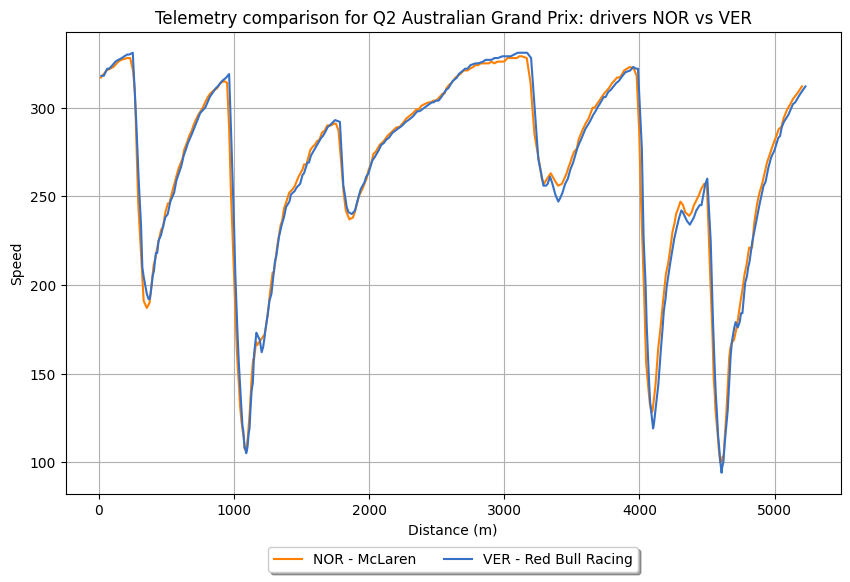

In [ ]:
df, event_name = get_qualification_telemetry_df(
    f1_driver_laps_info,
    qual_australian_gp,
    f1_driver_telemetry,
    w1_fia_control,
    w1_events,
    9689,
    qual_dict,
    "Q2"
    )

visualize_qualification_telemetry(
    df,
    event_name,
    "Q2",
    ["NOR", "VER"],
    "Speed"  # DRS, RPM, nGear, Brake, Speed, Throttle
    )

The current F1 world champion struggled against McLaren in Q2. Due to the notebook's limitations, I can't pinpoint which exactly turns caused the issue (mean turns on circuit layout). However, the plot shows Verstappen struggled in the second and third low-speed corners and also in high-speed corners against McLaren.

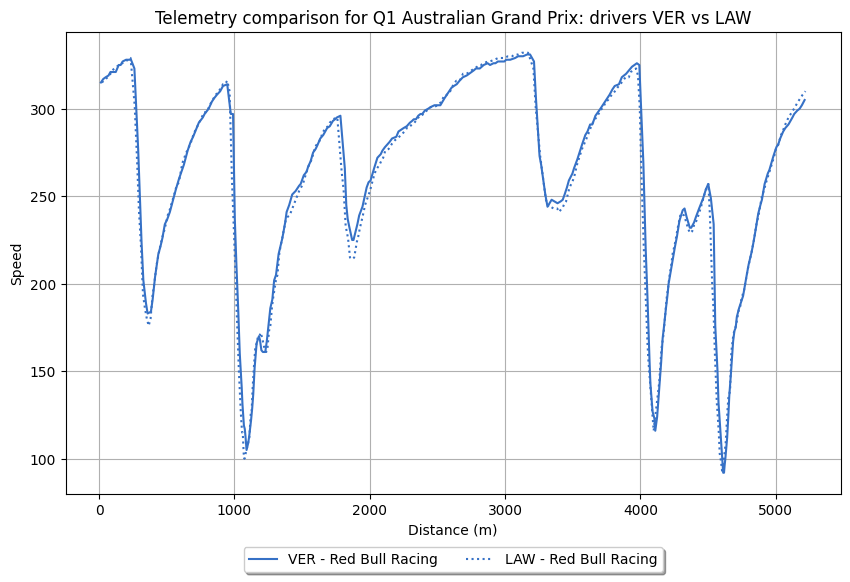

In [ ]:
df, event_name = get_qualification_telemetry_df(
    f1_driver_laps_info,
    qual_australian_gp,
    f1_driver_telemetry,
    w1_fia_control,
    w1_events,
    9689,
    qual_dict,
    "Q1"
    )

visualize_qualification_telemetry(
    df,
    event_name,
    "Q1",
    ["VER", "LAW"],
    "Speed"
    )

It's also interesting to compare Verstappen's speed with Red Bull rookie Liam Lawson. Lawson struggled with early braking and poor corner exits, costing him significant time.

### Compare just the best qualification laps between drivers through all qualification

In [ ]:
def get_qualification_best_lap_telemetry_df(laps_data, results_data, telemetry_data, event_data, session_key):
  event_name = get_session_df(event_data, session_key)['ShortName'].values[0]

  temp_qual_df = get_session_df(results_data, session_key)

  q1_session_df = temp_qual_df[["Abbreviation", "TeamName", "TeamColor", "Q1"]]
  q1_session_df.loc[:, "QSession"] = "Q1"
  q1_session_df = q1_session_df.rename(columns={"Q1": "Qtime"})

  q2_session_df = temp_qual_df[["Abbreviation", "TeamName", "TeamColor", "Q2"]]
  q2_session_df.loc[:, "QSession"] = "Q2"
  q2_session_df = q2_session_df.rename(columns={"Q2": "Qtime"})

  q3_session_df = temp_qual_df[["Abbreviation", "TeamName", "TeamColor", "Q3"]]
  q3_session_df.loc[:, "QSession"] = "Q3"
  q3_session_df = q3_session_df.rename(columns={"Q3": "Qtime"})

  qual_best = pd.concat([q1_session_df,
                        q2_session_df,
                        q3_session_df], axis=0)

  qual_best = qual_best.dropna(subset="Qtime")
  qual_best_part_1 = qual_best.groupby(["Abbreviation", "TeamName"])["Qtime"].min().reset_index().sort_values(by="Qtime")
  qual_best_full = qual_best[["Abbreviation", "Qtime", "TeamColor", "QSession"]].merge(qual_best_part_1, how="right", on=["Abbreviation", "Qtime"])

  qualification_laps_info_df = get_session_df(laps_data, session_key)
  qualification_laps_info_df = qualification_laps_info_df[qualification_laps_info_df["Deleted"] == False]
  q_with_laps_df = qual_best_full.merge(qualification_laps_info_df[["Driver", "LapTime", "DriverNumber", "LapNumber"]],
                                        how="left",
                                        left_on = ["Abbreviation", "Qtime"],
                                        right_on = ["Driver", "LapTime"])

  q_telemetry_df = get_session_df(telemetry_data, session_key)
  best_q_lap_telemetry_df = q_telemetry_df.merge(q_with_laps_df, how="right", on=["DriverNumber", "LapNumber"])

  return best_q_lap_telemetry_df, event_name


def visualize_qualification_best_lap_telemetry(prepared_data, event_name, picked_drivers, parametr):
  visualized_teams = []
  plt.figure(figsize=(10, 6))
  for driver in picked_drivers:
    data_for_plot = prepared_data[prepared_data["Driver"] == driver]
    team = data_for_plot["TeamName"].unique()[0]
    qualifying_session = data_for_plot["QSession"].unique()[0]
    linestyle = '-' if team not in visualized_teams else ':'
    color = data_for_plot["TeamColor"].iloc[0] if not data_for_plot["TeamColor"].isna().all() else "gray"
    plt.plot(data_for_plot["Distance"],
             data_for_plot[parametr],
             label=f"{driver} - {team} - {qualifying_session}",
             color="#" + color,
             linestyle=linestyle
             )
    visualized_teams.append(team)

  plt.title(f"Telemetry comparison for all qualification session {event_name}: drivers {picked_drivers[0]} vs {picked_drivers[1]}")
  plt.xlabel("Distance (m)")
  plt.ylabel(parametr)
  plt.legend(loc='upper center',
             bbox_to_anchor=(0.5, -0.1),
             fancybox=True,
             shadow=True,
             ncol=5
             )
  plt.grid(True)
  plt.show()

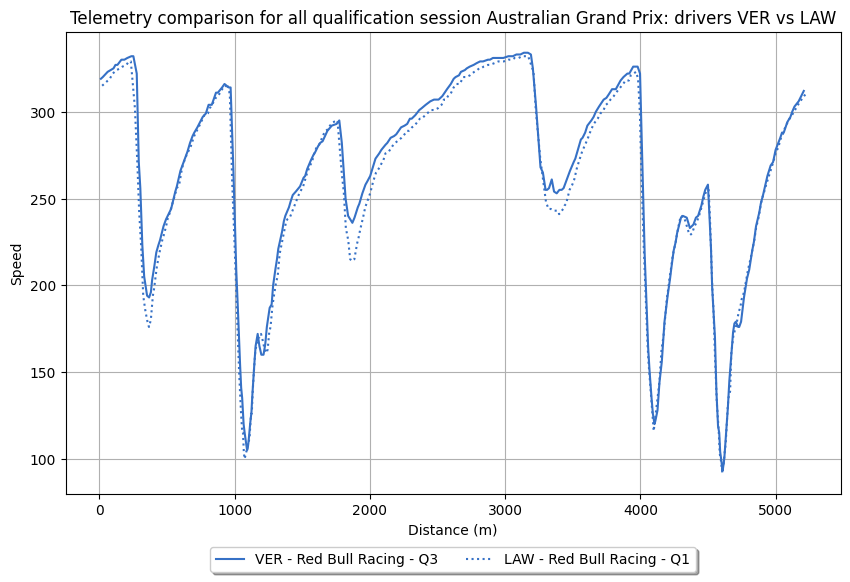

In [ ]:
df, event_name = get_qualification_best_lap_telemetry_df(
    f1_driver_laps_info,
    qual_australian_gp,
    f1_driver_telemetry,
    w1_events,
    9689
    )

visualize_qualification_best_lap_telemetry(
    df,
    event_name,
    ["VER", "LAW"],
    "Speed"
)

Comparing their best qualifying laps, Lawson struggled significantly against Verstappen. Let's also compare Lawson and his former teammate, Yuki Tsunoda.

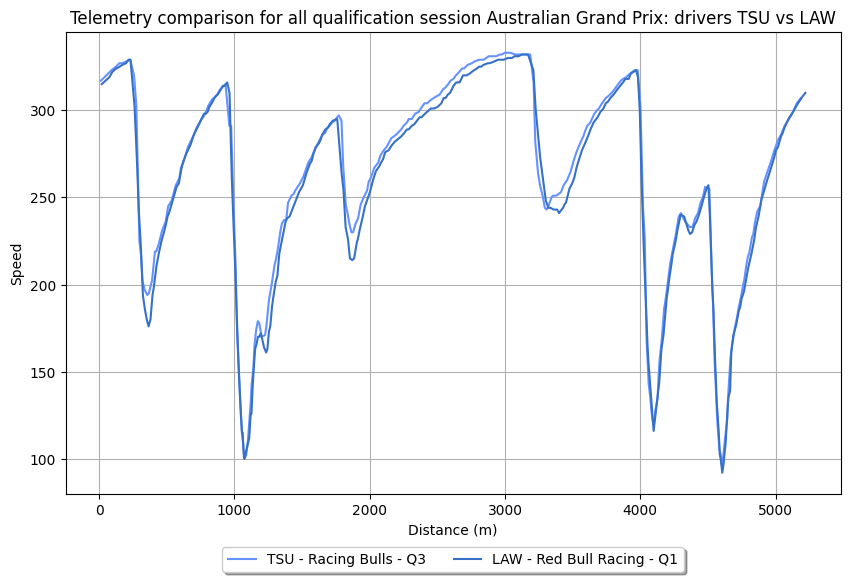

In [ ]:
visualize_qualification_best_lap_telemetry(
    df,
    event_name,
    ["TSU", "LAW"],
    "Speed"
)

### Other analysis

We also can do the same weather analysis during this qualification session and look at FIA control message and count some sort of statistic. But what really interesting during qualification session is deleted laps we can see how many laps was deleted and was this laps best for drivers?

In [ ]:
def get_qualification_deleted_laps(results_data, laps_data, fia_message_data, session_key):
  temp_laps_df = get_session_df(laps_data, session_key)
  temp_results_df = get_session_df(results_data, session_key)

  qual_green_time = fia_message_data[(fia_message_data["SessionKey"] == session_key) & (fia_message_data["Flag"] == 'GREEN')]['Time'].tolist()
  temp_laps_df["SessionNumber"] = temp_laps_df['LapStartDate'].apply(lambda x: 1 if x < qual_green_time[1] else 2 if qual_green_time[1] < x < qual_green_time[2] else 3)

  driver_deleted_max_lap = {}

  for row in temp_laps_df[temp_laps_df['Deleted'] == True][['Driver', 'LapTime', 'SessionNumber']].itertuples():
    if temp_laps_df[(temp_laps_df['Driver'] == row.Driver) & (temp_laps_df['SessionNumber']==row.SessionNumber)]['LapTime'].min() == row.LapTime:
      if driver_deleted_max_lap.get(row.Driver) is None:
        driver_deleted_max_lap[row.Driver] = 1
      else:
        driver_deleted_max_lap[row.Driver]+=1

  full_info = temp_laps_df.merge(temp_results_df, how="left", left_on="Driver", right_on="Abbreviation")
  df = full_info.groupby(["Driver", "TeamName"])["Deleted"].sum().reset_index().sort_values(by="Deleted", ascending=False).rename(columns={"Deleted": "NumOfDeletedLaps"})
  df = df[df["NumOfDeletedLaps"] != 0].reset_index(drop=True)

  df['IsDeletedLapsWasFastest'] = 0
  if len(driver_deleted_max_lap) != 0:
    print('here')
    for driver, max_deleted_laps_count in driver_deleted_max_lap.items():
      df.loc[df[df['Driver'] == driver].index, 'IsDeletedLapsWasFastest'] = max_deleted_laps_count

  return df

get_qualification_deleted_laps(w1_results, w1_laps, w1_fia_control, 9689)


,Driver,TeamName,NumOfDeletedLaps,IsDeletedLapsWasFastest
0,HUL,Kick Sauber,2,0
1,NOR,McLaren,1,0
2,DOO,Alpine,1,0
3,OCO,Haas F1 Team,1,0


All deleted laps weren't the drivers' fastest, so the deletions didn't hurt their qualifying times.

## Race

Finally the most interesting part of the race weekend - race. Here we can analyze much more things. For example: tyre strategy during race, intervals to leader, drivers and team cars pace during race, can compare the fastest driver lap, also see how weather can effect on team strategy or whatever.

### Drivers race tyres strategy

Teams and drivers choose specific tyres for the race to get maximum possible performance  so interesting to see that strategy. There are also some situations where it rains during the race, which can greatly affect race strategy.

In [ ]:
compound_colors = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFF200',
    'HARD': '#EBEBEB',
    'INTERMEDIATE': '#39B54A',
    'WET': '#00AEEF',
}

In [ ]:
def race_driver_stints_df(laps_data, session_key):
  race_laps_df = get_session_df(laps_data, session_key)

  driver_stints_df = race_laps_df[
      ['Driver', 'Stint','Compound','LapNumber']].groupby(
          ['Driver', 'Stint', 'Compound']).count().reset_index()

  driver_stints_df = driver_stints_df.sort_values(by=['Stint'])

  return driver_stints_df

In [ ]:
def race_tyres_strategy(event_data, results_data, driver_stints, tyre_colors, session_key):
  temp_event_df = get_session_df(event_data, session_key)
  session_name = temp_event_df["ShortName"].values[0]
  session_weekend = temp_event_df["WeekendNumber"].values[0]
  session_results = get_session_df(results_data, session_key)


  fig, ax = plt.subplots()
  for driver in session_results['Abbreviation']:
      stints = driver_stints.loc[driver_stints['Driver'] == driver]

      previous_stint_end = 0
      for _, stint in stints.iterrows():
          plt.barh(
              [driver],
              stint['LapNumber'],
              left=previous_stint_end,
              color=tyre_colors.get(stint['Compound']),
              edgecolor = 'black'
          )

          previous_stint_end = previous_stint_end + stint['LapNumber']

  plt.title(f'Tyre strategy: weekend {session_weekend} - {session_name}')

  plt.xlabel('Lap')
  plt.gca().invert_yaxis()

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.show()

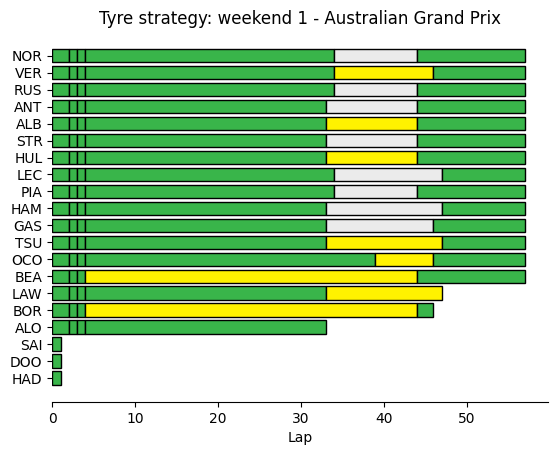

In [ ]:
stints_df = race_driver_stints_df(f1_driver_laps_info, 9693)
race_tyres_strategy(f1_events_info,
                    f1_results_info,
                    stints_df,
                    compound_colors,
                    9693)

Wee see that drivers use INTERMEDIATE tyres what can say about rain/wet condition, let's check it by analysing rainfall data.

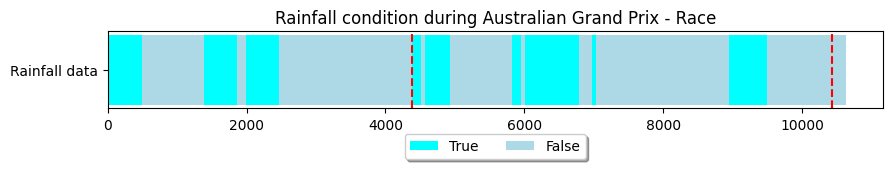

In [ ]:
visualize_rainfall_data_through_session(w1_weather, w1_laps, w1_events, 9693)

It was very wet during the race, but the data is limited. Some drivers used slicks even in the rain. From laps 32-45, it was dry, and everyone used HARD or MEDIUM tires. But after again wet condition.

### Drivers pace

#### Raw driver pace comparison during race

We can compare drivers pace by each lap. First of all let's see raw driver pace (lap time) by laps.

In [ ]:
def get_drivers_raw_pace_df(laps_data, results_data, session_key):
  temp_laps_df = get_session_df(laps_data, session_key)
  temp_laps_df["LapTimeSeconds"] = temp_laps_df["LapTime"].dt.total_seconds()
  temp_results_df = get_session_df(results_data, session_key)
  temp_merged_df = temp_laps_df.merge(
      temp_results_df[["Abbreviation","TeamName", "TeamColor"]],
      how="left",
      left_on="Driver",
      right_on="Abbreviation"
      )

  return temp_merged_df


def visulaize_drivers_raw_pace(prepared_data, picked_drivers):
  visualized_teams = []
  plt.figure(figsize=(10, 6))
  for driver in picked_drivers:
    data_for_plot = prepared_data[prepared_data["Driver"] == driver]
    team = data_for_plot["TeamName"].unique()[0]
    # return team
    linestyle = '-' if team not in visualized_teams else ':'
    color = data_for_plot["TeamColor"].iloc[0] if not data_for_plot["TeamColor"].isna().all() else "gray"
    # return color
    plt.plot(data_for_plot["LapNumber"],
             data_for_plot["LapTimeSeconds"],
             label=f"{driver} - {team}",
             color="#" + color,
             linestyle=linestyle
             )
    visualized_teams.append(team)

  plt.title(f"Raw race pace: drivers {picked_drivers[0]} vs {picked_drivers[1]}")
  plt.xlabel("Lap")
  plt.ylabel("Lap time in seconds")
  plt.legend()
  plt.grid(True)
  plt.show()

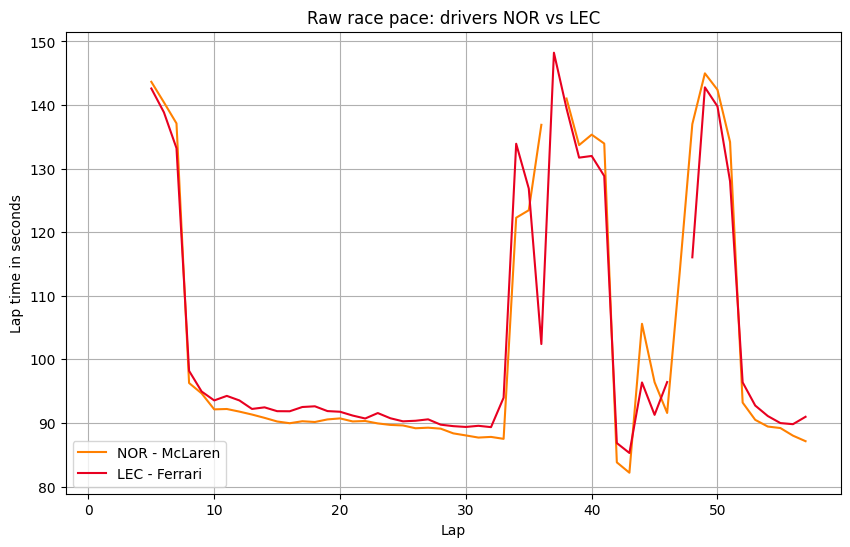

In [ ]:
# or drivers from the same team
df = get_drivers_raw_pace_df(
    w1_laps,
    w1_results,
    9693
    )
visulaize_drivers_raw_pace(df, ["NOR", "LEC"])

The data has some missing points, which affects plot clarity. However, we can still see key insights, such as numerous safety car periods and Ferrari losing pace to McLaren.

#### Driver pace without outliers in the race

To see more clear pace we can just remove outliers from our session race data.

In [ ]:
# let's see for example what we get from removing time outliers
australian_laps_data = get_session_df(w1_laps, 9693)
australian_laps_data["LapTimeSeconds"] = australian_laps_data["LapTime"].dt.total_seconds()
clear_laps_df = australian_laps_data[(australian_laps_data["PitOutTime"].isna()) & (australian_laps_data["PitInTime"].isna())]

In [ ]:
q75, q25 = clear_laps_df["LapTimeSeconds"].quantile(0.75), clear_laps_df["LapTimeSeconds"].quantile(0.25)

intr_qr = q75 - q25
laptime_max = q75 + (1.5 * intr_qr) # IQR: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR: Min = q25 + 1,5 * IQR

clear_laps_df.loc[clear_laps_df['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
clear_laps_df.loc[clear_laps_df['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

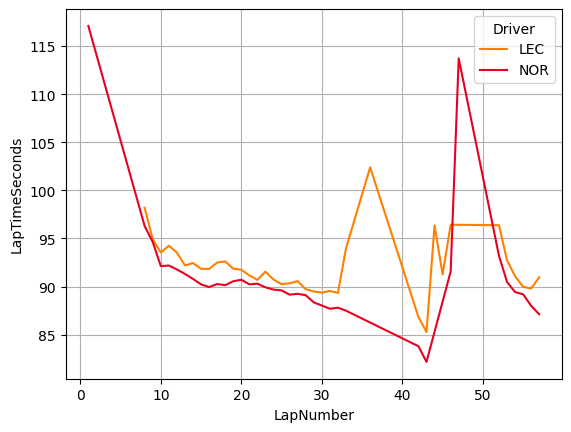

In [ ]:
drivers = ["NOR", "LEC"]
ver_alo_race_clear_laps = clear_laps_df[clear_laps_df["Driver"].isin(drivers)]
sns.lineplot(data=ver_alo_race_clear_laps, x="LapNumber", y="LapTimeSeconds", hue="Driver", palette=['#FF8000', '#E80020'])
plt.grid(True)
plt.show()

In overall see nearly the same what we get previously, but without big outliers, what in some situation might be significant.

### Comparision all drivers pace during race

In [ ]:
def get_cleaned_race_pace_df(laps_data, results_data, session_key):
  temp_laps_df = get_session_df(laps_data, session_key)
  temp_laps_df["LapTimeSeconds"] = temp_laps_df["LapTime"].dt.total_seconds()
  clear_laps_df = temp_laps_df[(temp_laps_df["PitOutTime"].isna()) & (temp_laps_df["PitInTime"].isna())]

  q75, q25 = clear_laps_df["LapTimeSeconds"].quantile(0.75), clear_laps_df["LapTimeSeconds"].quantile(0.25)

  intr_qr = q75 - q25
  laptime_max = q75 + (1.5 * intr_qr)
  laptime_min = q25 - (1.5 * intr_qr)

  clear_laps_df.loc[clear_laps_df['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
  clear_laps_df.loc[clear_laps_df['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

  temp_results_df = get_session_df(results_data, session_key)
  temp_merged_df = clear_laps_df.merge(
      temp_results_df[["Abbreviation","TeamName", "TeamColor"]],
      how="left",
      left_on="Driver",
      right_on="Abbreviation"
      )

  return temp_merged_df

In [ ]:
temporary_df = get_cleaned_race_pace_df(w1_laps, w1_results, 9693)

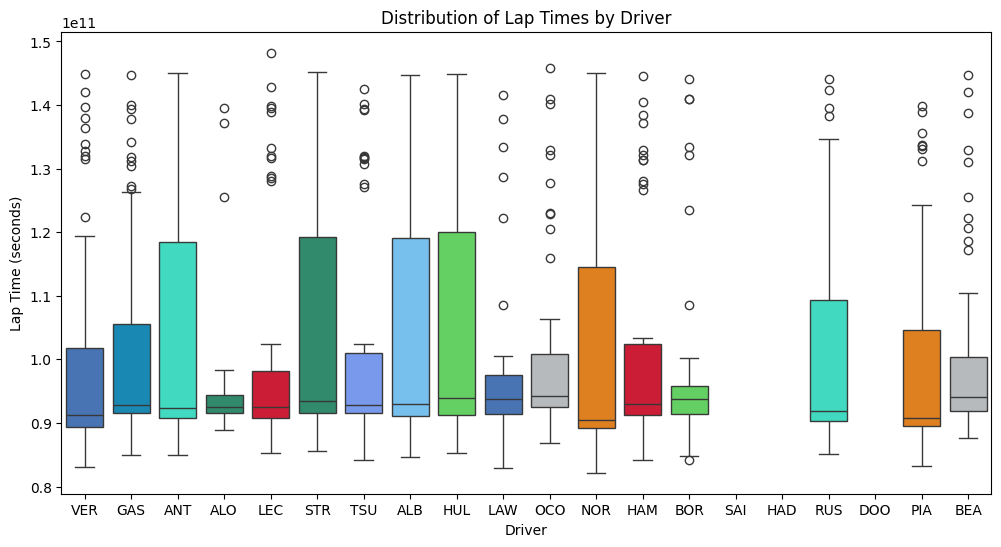

In [ ]:
def visualize_driver_race_pace(prepared_data):
  driver_team_colors = dict(zip(prepared_data["Driver"], "#" + prepared_data["TeamColor"]))

  plt.figure(figsize=(12, 6))
  sns.boxplot(
      x="Driver", y="LapTime", data=prepared_data,
      palette=driver_team_colors
  )

  plt.gca().invert_yaxis()
  plt.xlabel("Driver")
  plt.ylabel("Lap Time (seconds)")
  plt.title("Distribution of Lap Times by Driver")
  plt.show()

visualize_driver_race_pace(temporary_df)

Another way to see as much as possible drivers pace. And here we can see that Lando Norris have the best median pace what is absolutely incredibly result. Also see that three drivers don't have results, means that thay had crash in this race on first or warm-up laps. Also if we see on this plot again we will see that Verstappen pretty have pretty consistent race pace.

#### Smoothed driver pace

In [ ]:
def visualize_smoothed_race_pace(data, picked_drivers):
  plt.figure(figsize=(10, 6))
  visualized_teams = []

  for driver in picked_drivers:
    data_for_plot = data[data["Driver"] == driver][["LapNumber", "LapTimeSeconds", "TeamName", "TeamColor"]]
    data_for_plot = data_for_plot.dropna()
    team = data_for_plot["TeamName"].unique()[0]

    x = data_for_plot["LapNumber"]
    # EWMA for lap time in seconds
    # y_poly = data_for_plot['LapTimeSeconds'].ewm(span=5, adjust=False).mean()
    poly = np.polyfit(data_for_plot['LapNumber'], data_for_plot['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(data_for_plot['LapNumber'])

    linestyle = '-' if team not in visualized_teams else ':'
    color = data_for_plot["TeamColor"].iloc[0] if not data_for_plot["TeamColor"].isna().all() else "gray"
    plt.plot(
        x,
        y_poly,
        label=f"{driver} - {team}",
        color="#" + color,
        linestyle=linestyle
        )
    visualized_teams.append(team)

  plt.title(f"Raw race pace: drivers {picked_drivers[0]} vs {picked_drivers[1]}")
  plt.xlabel("Lap")
  plt.ylabel("Lap time in seconds")
  plt.legend()
  plt.grid(True)
  plt.show()

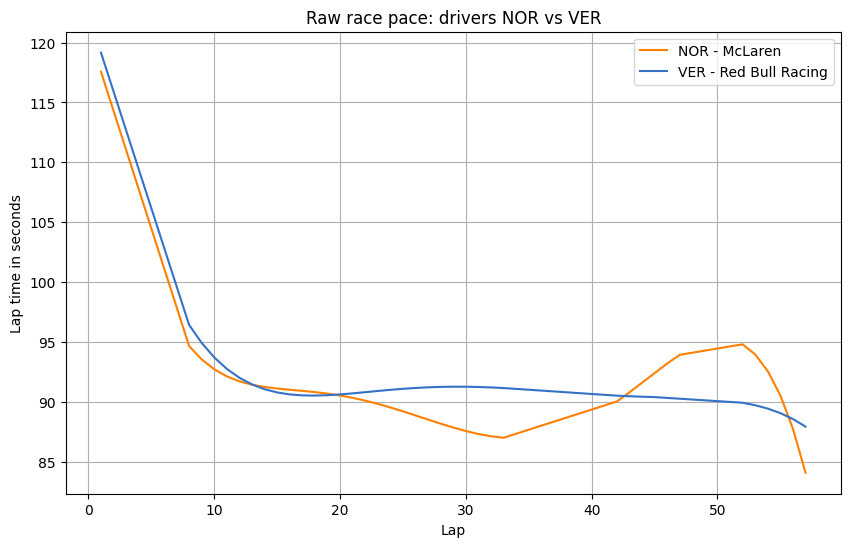

In [ ]:
visualize_smoothed_race_pace(temporary_df, ["NOR", "VER"])

See here that Verstappen get more smooth pace than Norris. This method effectively displays consistent driver pace by removing potential outliers, which may reflect unforeseen issues. For instance, Piastri's late-race gravel excursion significantly impacted his finishing position compared to his qualifying performance. Let's see that!

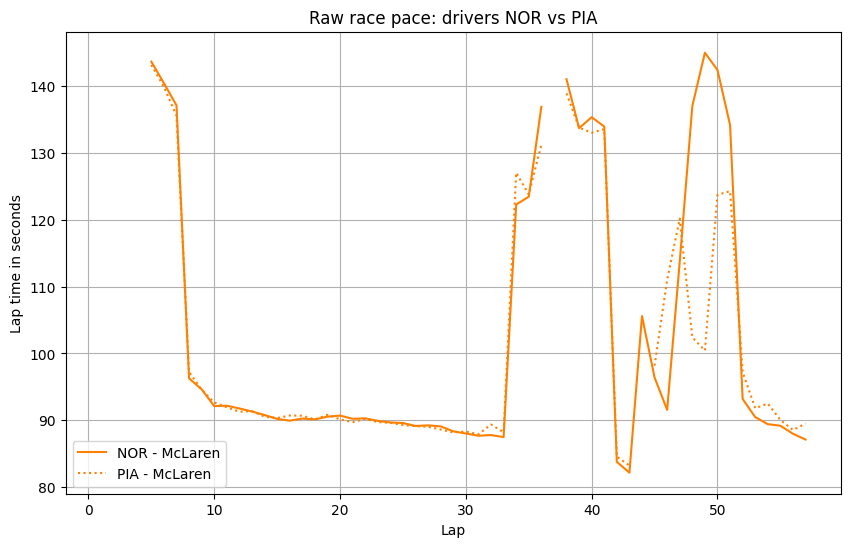

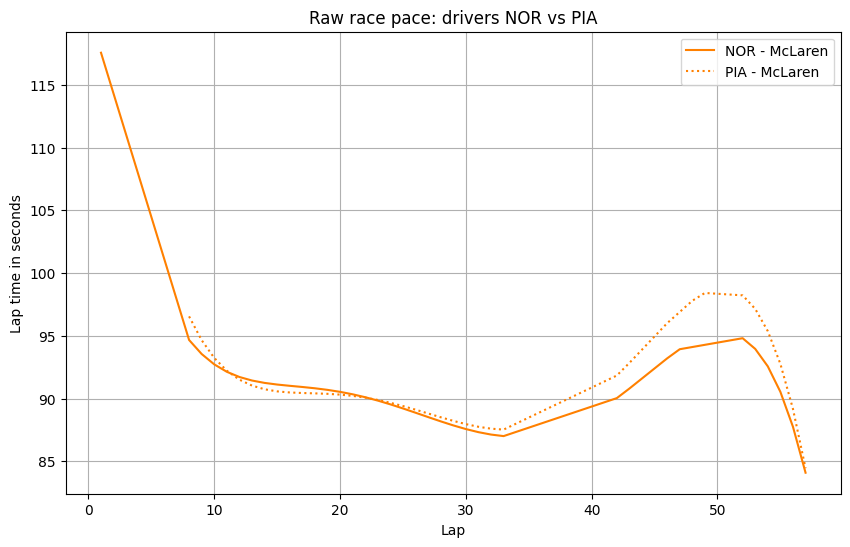

In [ ]:
visulaize_drivers_raw_pace(df, ["NOR", "PIA"])
visualize_smoothed_race_pace(temporary_df, ["NOR", "PIA"])

We can see the significant time loss at the race's end, which isn't visible in the smoothed pace plot, highlighting a weakness of this method. But in overall we see that Oscar Piastri have pretty same consistent pace like his teammate Lando Norris.

### Drivers intervals with respect to leader

In [ ]:
def interval_to_leader_df(laps_data, results_data, session_key):
  final_data = pd.DataFrame()
  temp_race_lap_df = get_session_df(laps_data, session_key)
  temp_race_results_df = get_session_df(results_data, session_key)

  for lap in temp_race_lap_df["LapNumber"].unique():
    info_by_lap_df = temp_race_lap_df[temp_race_lap_df["LapNumber"] == lap]

    if len(info_by_lap_df[info_by_lap_df["LapStartTime"] == info_by_lap_df["LapStartTime"].min()]) > 1:
      leader_name = temp_race_results_df[temp_race_results_df["GridPosition"] == 1]["Abbreviation"].values[0]
      leader_time = info_by_lap_df[info_by_lap_df["Driver"] == leader_name]["LapStartTime"].iloc[0]
    else:
      leader_name = info_by_lap_df[info_by_lap_df["LapStartTime"] == info_by_lap_df["LapStartTime"].min()]["Driver"].iloc[0]
      leader_time = info_by_lap_df[info_by_lap_df["LapStartTime"] == info_by_lap_df["LapStartTime"].min()]["LapStartTime"].iloc[0]

    for driver in info_by_lap_df["Driver"].unique():
        driver_time = info_by_lap_df[info_by_lap_df["Driver"] == driver]["LapStartTime"].iloc[0]
        time_differences = driver_time - leader_time
        time_differences = time_differences.total_seconds()
        if time_differences != 0:
          time_differences = - time_differences
        interval_data = {
            "lap": [lap],
            "driver_code": [driver],
            "interval_to_leader": [time_differences]
        }
        driver_interval_time_df = pd.DataFrame(interval_data)
        final_data = pd.concat([final_data, driver_interval_time_df], ignore_index=True)

  return final_data

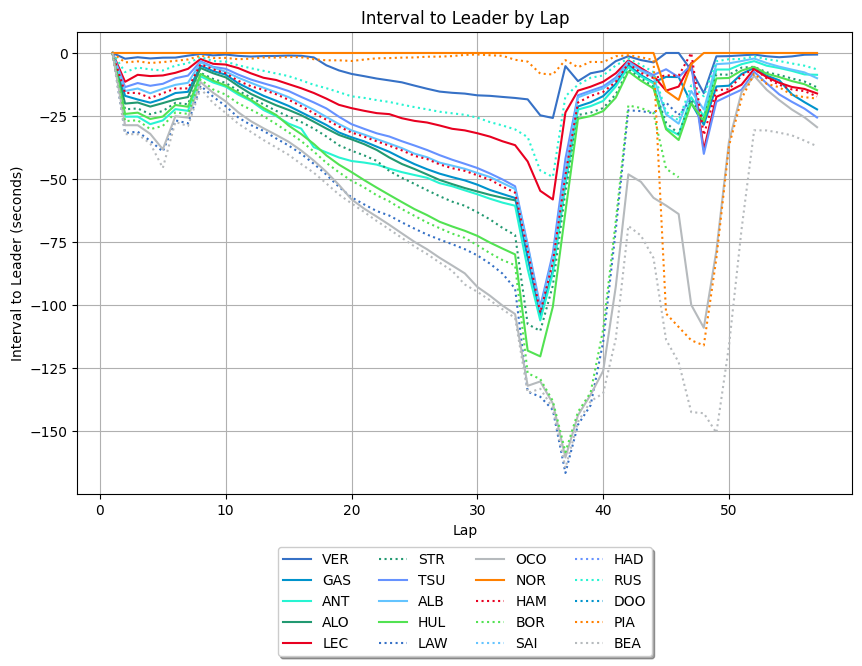

In [ ]:
def plot_driver_intervals(data, results_data, session_key):
  temp_race_results_df = get_session_df(results_data, session_key)
  full_dataset = data.merge(temp_race_results_df, how="left", left_on="driver_code", right_on="Abbreviation")
  visualized_teams = []


  plt.figure(figsize=(10, 6))
  for driver in full_dataset["driver_code"].unique():
    data_for_plot = full_dataset[full_dataset["driver_code"] == driver]
    team = data_for_plot["TeamName"].unique()[0]
    linestyle = '-' if team not in visualized_teams else ':'
    color = data_for_plot["TeamColor"].iloc[0] if not data_for_plot["TeamColor"].isna().all() else "gray"
    plt.plot(data_for_plot["lap"], data_for_plot["interval_to_leader"], label=f"{driver}", color="#" + color, linestyle=linestyle)
    visualized_teams.append(team)

  plt.xlabel("Lap")
  plt.ylabel("Interval to Leader (seconds)")
  plt.title("Interval to Leader by Lap")
  plt.legend(loc='upper center',
            bbox_to_anchor=(0.5, -0.1),
            fancybox=True,
            shadow=True,
            ncol=4
            )

  plt.grid()
  plt.show()

t1 = interval_to_leader_df(w1_laps, w1_results, 9693)
plot_driver_intervals(t1, w1_results, 9693)

In overall this graph about driver pace, but in some different way. From here we can see what happened in the race, but to be honest in my opinion this graph is too complicated to see specific driver fast, so let's improve this graph.

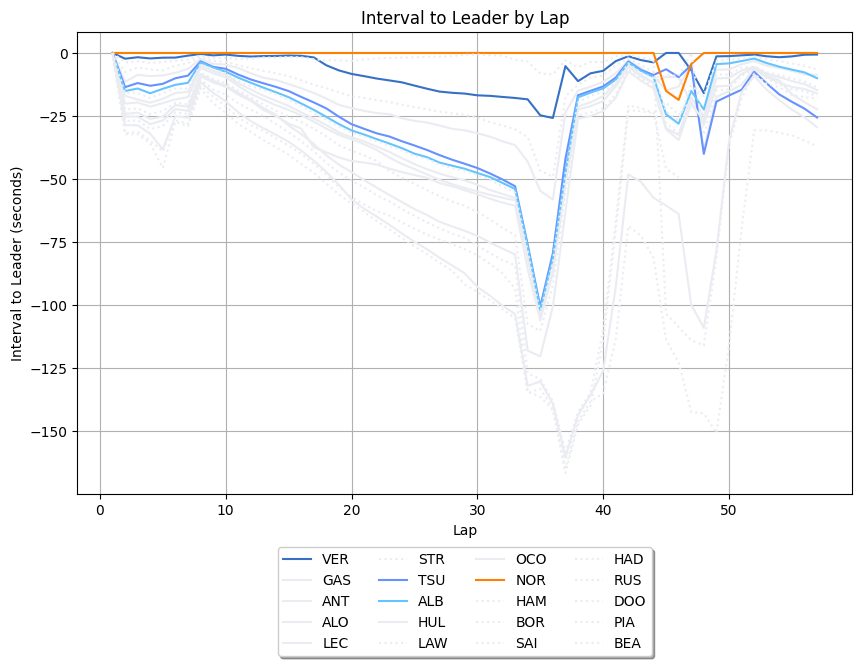

In [ ]:
def plot_driver_intervals_specific_drivers(data, results_data, session_key, picked_drivers):
  if len(picked_drivers) > 5:
    return "Pick less drivers"
  temp_race_results_df = get_session_df(results_data, session_key)
  full_dataset = data.merge(temp_race_results_df, how="left", left_on="driver_code", right_on="Abbreviation")
  visualized_teams = []

  plt.figure(figsize=(10, 6))
  for driver in full_dataset["driver_code"].unique():
    data_for_plot = full_dataset[full_dataset["driver_code"] == driver]
    team = data_for_plot["TeamName"].unique()[0]
    linestyle = '-' if team not in visualized_teams else ':'
    if driver in picked_drivers:
      color = data_for_plot["TeamColor"].iloc[0] if not data_for_plot["TeamColor"].isna().all() else "gray"
    else:
      color = "eaecf1"

    plt.plot(data_for_plot["lap"], data_for_plot["interval_to_leader"], label=f"{driver}", color="#" + color, linestyle=linestyle)
    visualized_teams.append(team)

  plt.xlabel("Lap")
  plt.ylabel("Interval to Leader (seconds)")
  plt.title("Interval to Leader by Lap")
  plt.legend(loc='upper center',
            bbox_to_anchor=(0.5, -0.1),
            fancybox=True,
            shadow=True,
            ncol=4
            )

  plt.grid()
  plt.show()

t1 = interval_to_leader_df(w1_laps, w1_results, 9693)
plot_driver_intervals_specific_drivers(t1, w1_results, 9693, ["NOR", "VER", "ALB", "TSU"])

This format improves readability and allows for quick driver comparisons, highlighting rivalries. Notably, Verstappen closed in on Lando at the race's end. Additionally, the midfield battle between Albon and Tsunoda is visible. Tsunoda lost significant time during his final pit stop.

### Driver fastest lap comparison

In [ ]:
def get_fastest_driver_lap_df(laps_data, results_data, telemetry_data, session_key):

  session_laps_df = get_session_df(laps_data, session_key)
  session_laps_df = session_laps_df[session_laps_df["Deleted"] == False]
  session_results_df = get_session_df(results_data, session_key)
  session_telemetry_df = get_session_df(telemetry_data, session_key)

  temp_df = session_laps_df.groupby("Driver")["LapTime"].min().reset_index()
  driver_fastest_laps_df = temp_df.merge(
      session_laps_df,
      how="inner",
      on=["Driver", "LapTime"]
      )

  drivers_fastest_lap_telemetry = session_telemetry_df.merge(
      driver_fastest_laps_df[["Driver", "DriverNumber", "LapNumber"]],
      how="inner",
      on=["DriverNumber", "LapNumber"]
      )

  complete_info_df = drivers_fastest_lap_telemetry.merge(
      session_results_df[["Abbreviation", "TeamName",	"TeamColor"]],
      how="left",
      left_on="Driver",
      right_on="Abbreviation"
  )
  return complete_info_df


# no more than 2 drivers
def visualize_drivers_fastest_lap_telemetry(prepared_data, picked_drivers, parametr):
  visualized_teams = []
  plt.figure(figsize=(10, 6))
  for driver in picked_drivers:
    driver_data = prepared_data[prepared_data["Driver"] == driver]
    team = driver_data["TeamName"].unique()[0]
    lap = driver_data["LapNumber"].unique()[0]

    linestyle = '-' if team not in visualized_teams else ':'
    color = driver_data["TeamColor"].iloc[0] if not driver_data["TeamColor"].isna().all() else "gray"
    plt.plot(
        driver_data["Distance"],
        driver_data[parametr],
        label=f"{driver} - {team} - {lap} lap",
        color="#" + color,
        linestyle=linestyle
        )
    visualized_teams.append(team)

  plt.title(f"Race fastest lap telemetry - {parametr}")
  plt.xlabel("Distance (m)")
  plt.ylabel(parametr)
  plt.legend(loc='upper center',
             bbox_to_anchor=(0.5, -0.1),
             fancybox=True,
             shadow=True,
             ncol=5
             )
  plt.grid(True)
  plt.show()

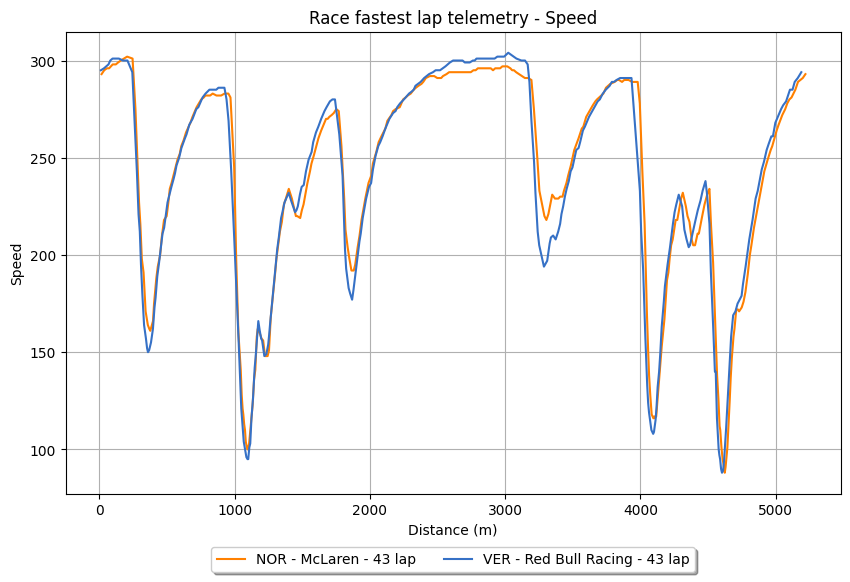

In [ ]:
df = get_fastest_driver_lap_df(
    w1_laps,
    w1_results,
    w1_driver_telemetry,
    9693
    )
visualize_drivers_fastest_lap_telemetry(
    df,
    ["NOR", "VER"],
    "Speed"  # RPM, Speed, nGear, Throttle, Brake, DRS
    )

Overall, the race data mirrors the qualification results. Max struggled in some medium and low-speed corners. However, Lando had the lowest straight-line speed. Interestingly, both drivers set their fastest laps on lap 43.

DONE